# Final code for training

* Cross validation for all models, display their confusion matrix
* Training using grid search for XGBoost and LightGBM

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:


DATA_PATH = "thai_road_accident_2019_2022.csv"

# Load dataset
df = pd.read_csv(DATA_PATH)

# Drop rows with missing latitude/longitude
df = df.dropna(subset=['latitude','longitude']).reset_index(drop=True)

# Target: severity
df['severity'] = np.where(df['number_of_fatalities']>0, 'high', 'low')
df['severity'] = pd.Categorical(df['severity'], categories=['low','high'], ordered=True)

# Extract datetime features
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'], errors='coerce')
df = df.dropna(subset=['incident_datetime']).reset_index(drop=True)
df['hour'] = df['incident_datetime'].dt.hour
df['weekday'] = df['incident_datetime'].dt.weekday
df['month'] = df['incident_datetime'].dt.month

# Grid count feature (approximate accident density)
df['lat_round3'] = df['latitude'].round(3)
df['lon_round3'] = df['longitude'].round(3)
grid_counts = df.groupby(['lat_round3','lon_round3']).size().rename('grid_count').reset_index()
df = df.merge(grid_counts, on=['lat_round3','lon_round3'], how='left')
df['grid_count'] = df['grid_count'].fillna(0).astype(int)


In [4]:
df['province_en'].value_counts()

province_en
Bangkok              6089
Chon Buri            4120
Chiang Mai           3407
Nakhon Ratchasima    3330
Suphan Buri          3056
                     ... 
Nong Bua Lam Phu      288
Phichit               226
Amnat Charoen         196
Ranong                140
unknown                25
Name: count, Length: 78, dtype: int64

In [5]:
# Numeric features
numeric_feats = ['number_of_vehicles_involved','latitude','longitude','grid_count','hour','weekday','month']

# Categorical features
cat_feats = ['province_en','vehicle_type','presumed_cause','accident_type',
             'weather_condition','road_description','slope_description']

# Reduce high-cardinality categorical features (top-N)
TOPN = 30
for c in ['presumed_cause']:
    top = df[c].value_counts().nlargest(TOPN).index
    df[c] = df[c].fillna('Missing').astype(str)
    df[c] = df[c].where(df[c].isin(top), other='Other')

FEATURES = numeric_feats + cat_feats
X = df[FEATURES]
y = (df['severity']=='high').astype(int)


In [6]:



num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, cat_feats)
], remainder='drop', sparse_threshold=0.3)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:


# Logistic Regression
pipe_lr = Pipeline([('pre', preprocessor),
                    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))])

# Random Forest
pipe_rf = Pipeline([('pre', preprocessor),
                    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))])

# XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
pipe_xgb = Pipeline([('pre', preprocessor),
                     ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                               scale_pos_weight=scale_pos_weight, random_state=42))])

# Optional: LightGBM
try:
    import lightgbm as lgb
    pipe_lgb = Pipeline([('pre', preprocessor),
                         ('clf', lgb.LGBMClassifier(random_state=42, is_unbalance=True))])
    LGB_AVAILABLE = True
except Exception:
    LGB_AVAILABLE = False



=== LR ===
Train recall: 0.7078859681599408
Validation recall: 0.7038499506416585
Validation F1: 0.4298417483044461
Validation ROC-AUC: 0.8072311529069465
              precision    recall  f1-score   support

           0     0.9486    0.7766    0.8540     14250
           1     0.3094    0.7038    0.4298      2026

    accuracy                         0.7676     16276
   macro avg     0.6290    0.7402    0.6419     16276
weighted avg     0.8690    0.7676    0.8012     16276


=== RF ===
Train recall: 1.0
Validation recall: 0.20533070088845015
Validation F1: 0.31278195488721805
Validation ROC-AUC: 0.8280459119170086
              precision    recall  f1-score   support

           0     0.8971    0.9847    0.9388     14250
           1     0.6562    0.2053    0.3128      2026

    accuracy                         0.8877     16276
   macro avg     0.7766    0.5950    0.6258     16276
weighted avg     0.8671    0.8877    0.8609     16276



c:\Users\gaurav\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:03:23] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGB ===
Train recall: 0.823768974453906
Validation recall: 0.7161895360315893
Validation F1: 0.47041659912465555
Validation ROC-AUC: 0.8351741570114822
              precision    recall  f1-score   support

           0     0.9526    0.8111    0.8762     14250
           1     0.3502    0.7162    0.4704      2026

    accuracy                         0.7993     16276
   macro avg     0.6514    0.7636    0.6733     16276
weighted avg     0.8776    0.7993    0.8257     16276

[LightGBM] [Info] Number of positive: 8103, number of negative: 56997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 65100, number of used features: 162
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [I

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LGB ===
Train recall: 0.7772429964210786
Validation recall: 0.7502467917077986
Validation F1: 0.4617253948967193
Validation ROC-AUC: 0.8403737032611144
              precision    recall  f1-score   support

           0     0.9568    0.7868    0.8635     14250
           1     0.3335    0.7502    0.4617      2026

    accuracy                         0.7823     16276
   macro avg     0.6451    0.7685    0.6626     16276
weighted avg     0.8792    0.7823    0.8135     16276



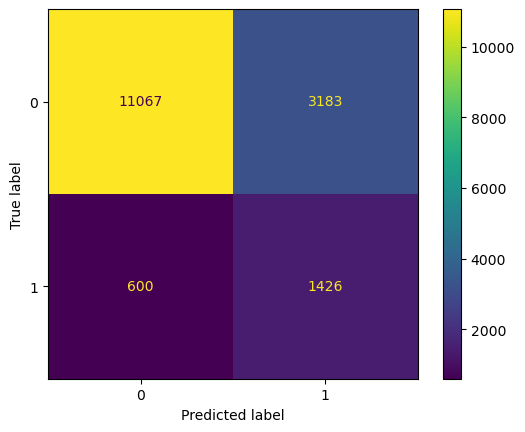

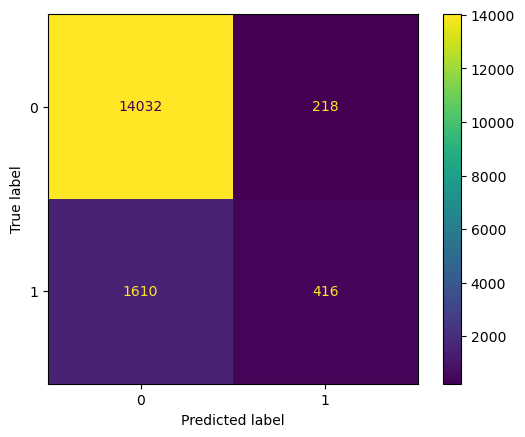

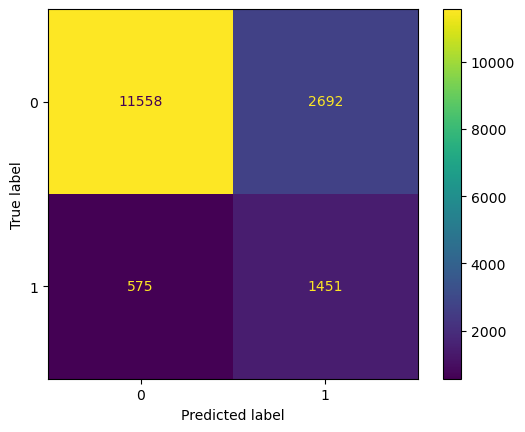

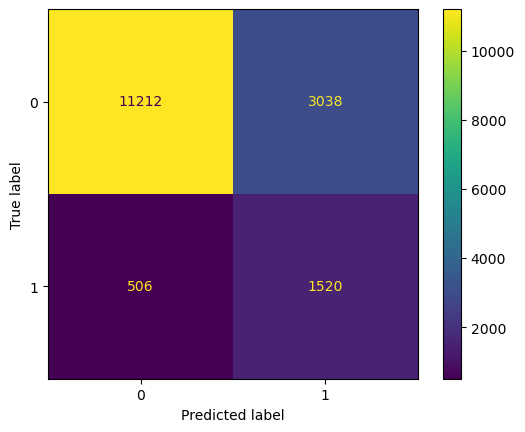

In [9]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

models = {'LR': pipe_lr, 'RF': pipe_rf, 'XGB': pipe_xgb}
if LGB_AVAILABLE:
    models['LGB'] = pipe_lgb

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = pipe.predict(X_train)
    y_pred_val = pipe.predict(X_val)
    y_proba_val = pipe.predict_proba(X_val)[:,1]
    
    print(f"\n=== {name} ===")
    print("Train recall:", recall_score(y_train, y_pred_train))
    print("Validation recall:", recall_score(y_val, y_pred_val))
    print("Validation F1:", f1_score(y_val, y_pred_val))
    print("Validation ROC-AUC:", roc_auc_score(y_val, y_proba_val))
    print(classification_report(y_val, y_pred_val, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val)


In [10]:
import joblib

# Save preprocessor + model
joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(pipe_xgb, 'model_xgb.joblib')

# Dummy input for demo
dummy = pd.DataFrame([{
    'number_of_vehicles_involved': 3,
    'latitude': 13.7563,
    'longitude': 100.5018,
    'grid_count': 10,
    'hour': 18,
    'weekday': 4,
    'month': 7,
    'province_en': 'Bangkok',
    'vehicle_type': 'Car',
    'presumed_cause': 'Speeding',
    'accident_type': 'Collision',
    'weather_condition': 'Clear',
    'road_description': 'Highway',
    'slope_description': 'Flat'
}])

# Load and predict
model_loaded = joblib.load('model_xgb.joblib')
pred = model_loaded.predict(dummy)
pred_proba = model_loaded.predict_proba(dummy)[:,1]
print("Predicted severity:", pred[0], "with probability:", pred_proba[0])


Predicted severity: 0 with probability: 0.029087268


In [11]:
# Load dataset
df = pd.read_csv('thai_road_accident_2019_2022.csv')

# Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Convert datetime
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'], errors='coerce')
df = df.dropna(subset=['incident_datetime']).reset_index(drop=True)

# Remove rows with missing critical info (latitude/longitude optional)
df = df.dropna(subset=['number_of_fatalities']).reset_index(drop=True)

# Inspect
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81735 entries, 0 to 81734
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   acc_code                     81735 non-null  int64         
 1   incident_datetime            81735 non-null  datetime64[ns]
 2   report_datetime              81735 non-null  object        
 3   province_th                  81735 non-null  object        
 4   province_en                  81735 non-null  object        
 5   agency                       81735 non-null  object        
 6   route                        81735 non-null  object        
 7   vehicle_type                 81735 non-null  object        
 8   presumed_cause               81735 non-null  object        
 9   accident_type                81735 non-null  object        
 10  number_of_vehicles_involved  81735 non-null  int64         
 11  number_of_fatalities         81735 non-nu

C:\Users\gaurav\AppData\Local\Temp\ipykernel_4724\1901288436.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='severity', palette=['skyblue','salmon'])


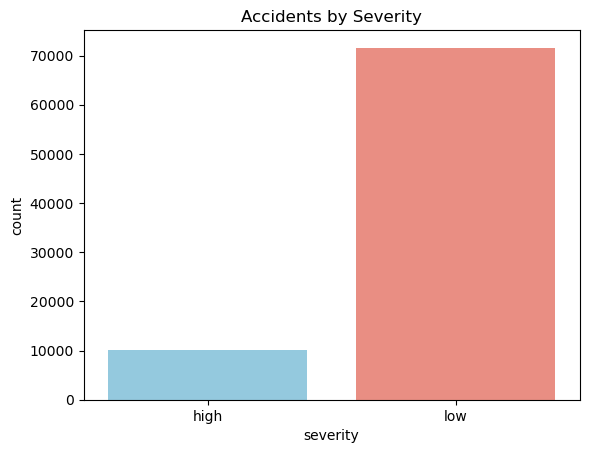

In [12]:
# Severity: 'high' if fatality, else 'low'
df['severity'] = np.where(df['number_of_fatalities'] > 0, 'high', 'low')
df['severity'] = df['severity'].astype('category')

# Check distribution
sns.countplot(data=df, x='severity', palette=['skyblue','salmon'])
plt.title("Accidents by Severity")
plt.show()


In [13]:
y = df['severity'].cat.codes  # 0=low, 1=high


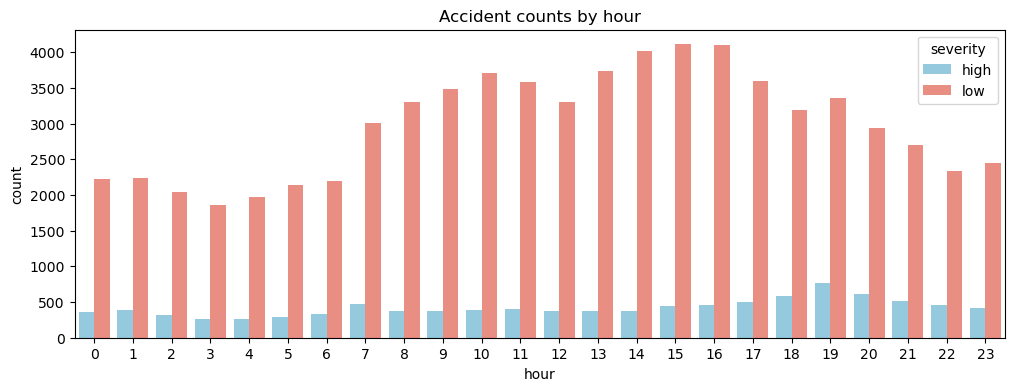

In [14]:
df['hour'] = df['incident_datetime'].dt.hour
df['weekday'] = df['incident_datetime'].dt.weekday
df['month'] = df['incident_datetime'].dt.month

# Plot accident counts by hour
plt.figure(figsize=(12,4))
sns.countplot(data=df, x='hour', hue='severity', palette=['skyblue','salmon'])
plt.title("Accident counts by hour")
plt.show()


In [15]:
categorical_cols = [
    'province_en', 'vehicle_type', 'presumed_cause',
    'accident_type', 'weather_condition', 'road_description', 'slope_description'
]

for col in categorical_cols:
    df[col] = df[col].astype('category').cat.codes


In [16]:
feature_cols = [
    'hour', 'weekday', 'month',
    'number_of_vehicles_involved', 'number_of_injuries', 'latitude', 'longitude'
] + categorical_cols

# Drop rows with missing latitude/longitude
df = df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)

X = df[feature_cols]
X.shape

(81376, 14)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best XGBoost params: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 159
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5402, number of negative: 37998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 43400, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8103, number of negative: 56997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 65100, number of used features: 162
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124470 -> initscore=-1.950764
[LightGBM] [Info] Start training from score -1.950764
Best LightGBM params: {'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__n_estimators': 100, 'clf__num_leaves': 70}

==== XGBoost ====
Recall: 0.711253701875617
F1-score: 0.4810549157068937
ROC-AUC: 0.8373410574808194
              precision    recall  f1-score   support

           0     0.9525    0.8229    0.8829     14250
           1     0.3634    0.7113    0.4811      2026

    accuracy                         0.8090     16276
  

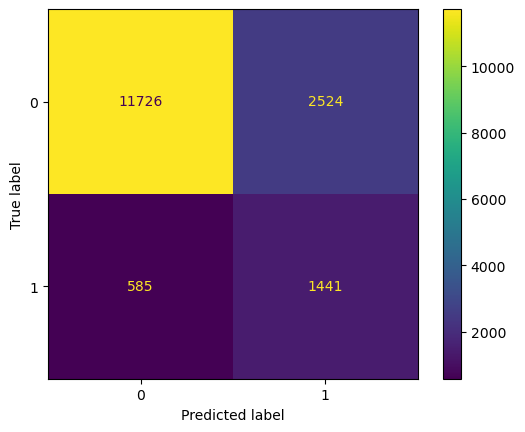

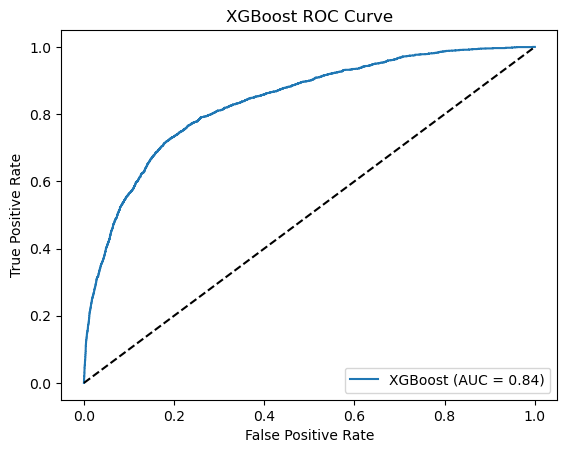

c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\gaurav\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



==== LightGBM ====
Recall: 0.4950641658440276
F1-score: 0.4701195219123506
ROC-AUC: 0.8279373928404427
              precision    recall  f1-score   support

           0     0.9271    0.9131    0.9201     14250
           1     0.4476    0.4951    0.4701      2026

    accuracy                         0.8611     16276
   macro avg     0.6873    0.7041    0.6951     16276
weighted avg     0.8674    0.8611    0.8641     16276



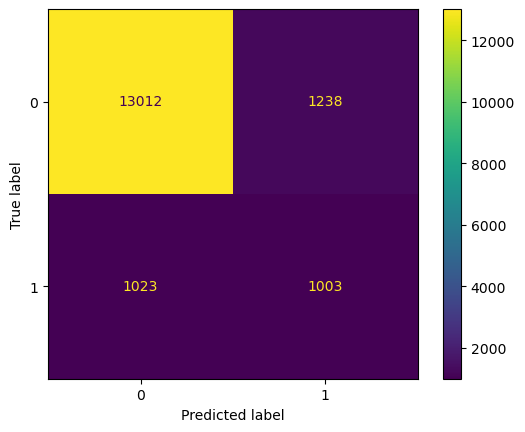

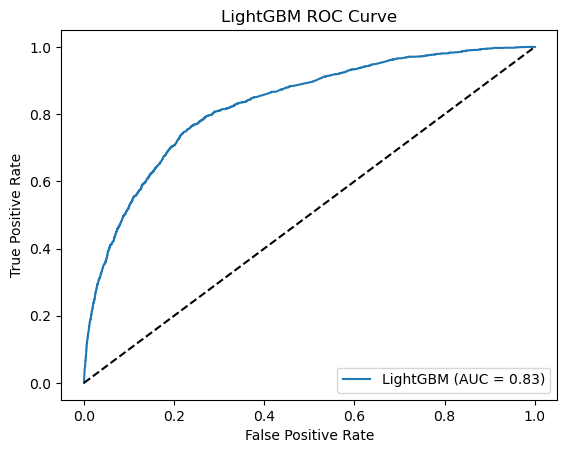

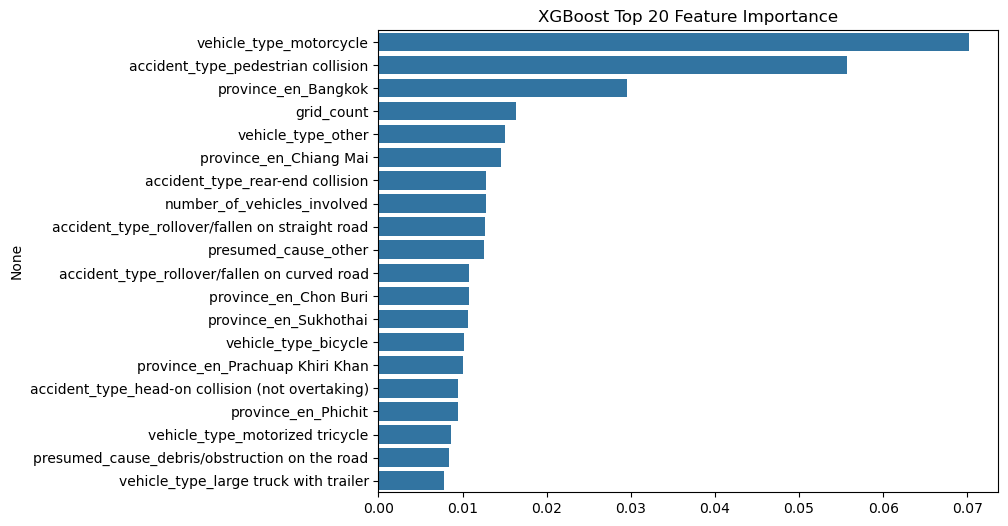

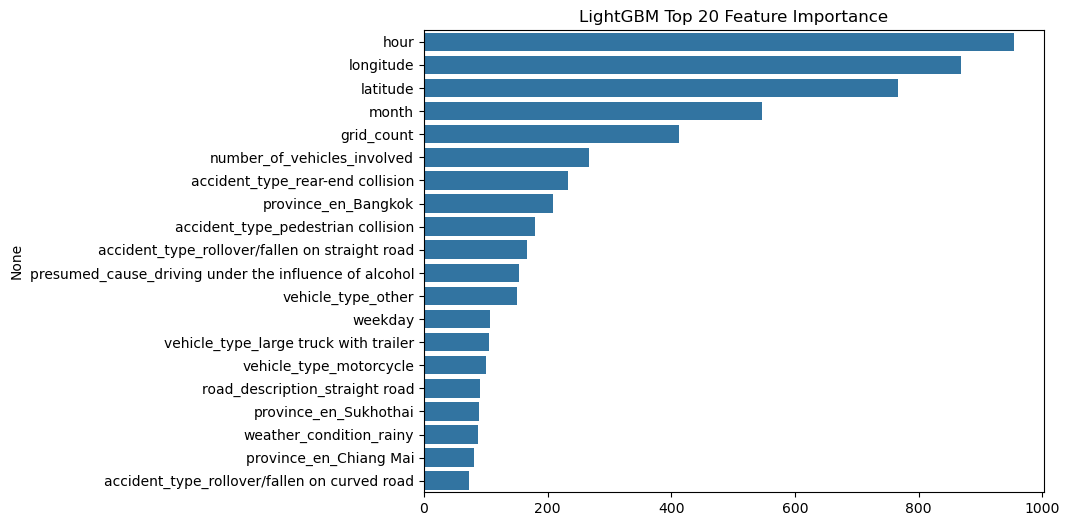

In [17]:


# Optional LightGBM
try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except:
    LGB_AVAILABLE = False

# -----------------------------
# Load & preprocess data
# -----------------------------
DATA_PATH = "thai_road_accident_2019_2022.csv"
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=['latitude','longitude']).reset_index(drop=True)

# Target
df['severity'] = np.where(df['number_of_fatalities']>0,'high','low')
y = (df['severity']=='high').astype(int)  # 0=low, 1=high

# Datetime features
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'], errors='coerce')
df = df.dropna(subset=['incident_datetime']).reset_index(drop=True)
df['hour'] = df['incident_datetime'].dt.hour
df['weekday'] = df['incident_datetime'].dt.weekday
df['month'] = df['incident_datetime'].dt.month

# Grid count
df['lat_round3'] = df['latitude'].round(3)
df['lon_round3'] = df['longitude'].round(3)
grid_counts = df.groupby(['lat_round3','lon_round3']).size().rename('grid_count').reset_index()
df = df.merge(grid_counts, on=['lat_round3','lon_round3'], how='left')
df['grid_count'] = df['grid_count'].fillna(0).astype(int)

# Features
numeric_feats = ['number_of_vehicles_involved','latitude','longitude','grid_count','hour','weekday','month']
cat_feats = ['province_en','vehicle_type','presumed_cause','accident_type',
             'weather_condition','road_description','slope_description']

# Reduce high-cardinality categorical
TOPN = 30
for c in ['presumed_cause']:
    top = df[c].value_counts().nlargest(TOPN).index
    df[c] = df[c].fillna('Missing').astype(str)
    df[c] = df[c].where(df[c].isin(top), other='Other')

X = df[numeric_feats + cat_feats]

# -----------------------------
# Preprocessing Pipeline
# -----------------------------
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, cat_feats)
])

# -----------------------------
# Train/Test Split
# -----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# Pipelines with class imbalance
# -----------------------------
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('clf', xgb.XGBClassifier(
        eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42
    ))
])

if LGB_AVAILABLE:
    pipe_lgb = Pipeline([
        ('pre', preprocessor),
        ('clf', lgb.LGBMClassifier(is_unbalance=True, random_state=42))
    ])

# -----------------------------
# Grid Search & CV
# -----------------------------
xgb_param_grid = {
    'clf__n_estimators':[100,200],
    'clf__max_depth':[3,5,7],
    'clf__learning_rate':[0.01,0.1],
    'clf__subsample':[0.8,1]
}

lgb_param_grid = {
    'clf__n_estimators':[100,200],
    'clf__max_depth':[3,5,7],
    'clf__learning_rate':[0.01,0.1],
    'clf__num_leaves':[31,50,70]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_search = GridSearchCV(pipe_xgb, xgb_param_grid, cv=cv, scoring='f1', verbose=1)
xgb_search.fit(X_train, y_train)
print("Best XGBoost params:", xgb_search.best_params_)

if LGB_AVAILABLE:
    lgb_search = GridSearchCV(pipe_lgb, lgb_param_grid, cv=cv, scoring='f1', verbose=1)
    lgb_search.fit(X_train, y_train)
    print("Best LightGBM params:", lgb_search.best_params_)

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, X_val, y_val, model_name='Model'):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    
    print(f"\n==== {model_name} ====")
    print("Recall:", recall_score(y_val, y_pred))
    print("F1-score:", f1_score(y_val, y_pred))
    print("ROC-AUC:", roc_auc_score(y_val, y_proba))
    print(classification_report(y_val, y_pred, digits=4))
    
    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# -----------------------------
# Feature Importance
# -----------------------------
def plot_feature_importance(model, preprocessor, model_name='Model', top_n=20):
    if model_name in ['XGBoost','LightGBM']:
        clf = model.named_steps['clf']
        # Get preprocessed feature names
        cat_features = model.named_steps['pre'].named_transformers_['cat']['ohe'].get_feature_names_out(cat_feats)
        all_features = np.concatenate([numeric_feats, cat_features])
        importances = clf.feature_importances_
        fi = pd.Series(importances, index=all_features).sort_values(ascending=False)[:top_n]
        plt.figure(figsize=(8,6))
        sns.barplot(x=fi.values, y=fi.index)
        plt.title(f'{model_name} Top {top_n} Feature Importance')
        plt.show()

# -----------------------------
# Evaluate
# -----------------------------
evaluate_model(xgb_search.best_estimator_, X_val, y_val, 'XGBoost')
if LGB_AVAILABLE:
    evaluate_model(lgb_search.best_estimator_, X_val, y_val, 'LightGBM')

plot_feature_importance(xgb_search.best_estimator_, preprocessor, 'XGBoost')
if LGB_AVAILABLE:
    plot_feature_importance(lgb_search.best_estimator_, preprocessor, 'LightGBM')

# -----------------------------
# Inference Function
# -----------------------------
def predict_new_csv(model, csv_path):
    df_new = pd.read_csv(csv_path)
    # Same preprocessing steps
    df_new['incident_datetime'] = pd.to_datetime(df_new['incident_datetime'], errors='coerce')
    df_new['hour'] = df_new['incident_datetime'].dt.hour
    df_new['weekday'] = df_new['incident_datetime'].dt.weekday
    df_new['month'] = df_new['incident_datetime'].dt.month
    df_new['lat_round3'] = df_new['latitude'].round(3)
    df_new['lon_round3'] = df_new['longitude'].round(3)
    grid_counts_new = df_new.groupby(['lat_round3','lon_round3']).size().rename('grid_count').reset_index()
    df_new = df_new.merge(grid_counts_new, on=['lat_round3','lon_round3'], how='left')
    df_new['grid_count'] = df_new['grid_count'].fillna(0).astype(int)
    
    # Handle top-N category
    for c in ['presumed_cause']:
        top = df[c].value_counts().nlargest(TOPN).index
        df_new[c] = df_new[c].fillna('Missing').astype(str)
        df_new[c] = df_new[c].where(df_new[c].isin(top), other='Other')
    
    X_new = df_new[numeric_feats + cat_feats]
    y_pred = model.predict(X_new)
    y_proba = model.predict_proba(X_new)[:,1]
    
    df_new['severity_pred'] = np.where(y_pred==1,'high','low')
    df_new['severity_proba'] = y_proba
    return df_new


In [18]:
import joblib

# Save XGBoost best model
# joblib.dump(xgb_search.best_estimator_, "BEST_XGBOOST_MODEL.pkl")
# print("XGBoost model saved as BEST_XGBOOST_MODEL.pkl")

# # Save LightGBM best model if available
# if LGB_AVAILABLE:
#     joblib.dump(lgb_search.best_estimator_, "BEST_LIGHTGBM_MODEL.pkl")
#     print("LightGBM model saved as BEST_LIGHTGBM_MODEL.pkl")


In [19]:
def predict_new_csv(model, csv_path):
    df_new = pd.read_csv(csv_path)
    # Same preprocessing steps
    df_new['incident_datetime'] = pd.to_datetime(df_new['incident_datetime'], errors='coerce')
    df_new['hour'] = df_new['incident_datetime'].dt.hour
    df_new['weekday'] = df_new['incident_datetime'].dt.weekday
    df_new['month'] = df_new['incident_datetime'].dt.month
    df_new['lat_round3'] = df_new['latitude'].round(3)
    df_new['lon_round3'] = df_new['longitude'].round(3)
    grid_counts_new = df_new.groupby(['lat_round3','lon_round3']).size().rename('grid_count').reset_index()
    df_new = df_new.merge(grid_counts_new, on=['lat_round3','lon_round3'], how='left')
    df_new['grid_count'] = df_new['grid_count'].fillna(0).astype(int)
    
    # Handle top-N category
    for c in ['presumed_cause']:
        top = df[c].value_counts().nlargest(TOPN).index
        df_new[c] = df_new[c].fillna('Missing').astype(str)
        df_new[c] = df_new[c].where(df_new[c].isin(top), other='Other')
    
    X_new = df_new[numeric_feats + cat_feats]
    y_pred = model.predict(X_new)
    y_proba = model.predict_proba(X_new)[:,1]
    
    df_new['severity_pred'] = np.where(y_pred==1,'high','low')
    df_new['severity_proba'] = y_proba
    return df_new

In [20]:
print(df['presumed_cause'].value_counts())

presumed_cause
speeding                                          60368
cutting in closely by people/vehicles/animals      6722
falling asleep                                     4700
vehicle equipment failure                          2747
driving under the influence of alcohol             1464
other                                              1226
running red lights/traffic signals                  911
unfamiliarity with the route/unskilled driving      677
illegal overtaking                                  445
debris/obstruction on the road                      294
failure to yield/signal                             214
tailgating                                          180
overloaded vehicle                                  176
abrupt lane change                                  134
failure to yield right of way                       133
worn-out/tire blowout                               127
Other                                               121
slippery road                    

In [21]:
xgb=joblib.load('BEST_XGBOOST_MODEL.pkl')

In [22]:
predict_new_csv(xgb, 'sample_accidents.csv')

,incident_datetime,province_en,latitude,longitude,vehicle_type,presumed_cause,accident_type,weather_condition,road_description,slope_description,...,number_of_injuries,number_of_fatalities,hour,weekday,month,lat_round3,lon_round3,grid_count,severity_pred,severity_proba
0,2021-03-15 08:23:00,Bangkok,13.7563,100.5018,Car,Other,Collision,Clear,Urban Road,Flat,...,1,0,8,0,3,13.756,100.502,1,low,0.461309
1,2021-03-15 14:40:00,Chiang Mai,18.7883,98.9853,Motorcycle,Other,Collision,Rain,Rural Road,Incline,...,2,0,14,0,3,18.788,98.985,1,low,0.132113
2,2021-04-10 19:10:00,Bangkok,13.7450,100.5400,Truck,Other,Overturn,Clear,Highway,Flat,...,0,1,19,5,4,13.745,100.540,1,low,0.213232
3,2021-05-22 09:15:00,Phuket,7.8804,98.3923,Car,Other,Collision,Clear,Urban Road,Flat,...,2,0,9,5,5,7.880,98.392,1,low,0.347235
4,2021-06-30 23:50:00,Khon Kaen,16.4419,102.8350,Motorcycle,Other,Overturn,Rain,Rural Road,Decline,...,1,1,23,2,6,16.442,102.835,1,high,0.544347
5,2021-03-12 07:40:00,Bangkok,13.7600,100.5200,Car,Other,Collision,Clear,Urban Road,Flat,...,1,0,7,4,3,13.760,100.520,1,high,0.668759
6,2021-04-18 22:10:00,Chiang Mai,18.7800,98.9900,Truck,Other,Overturn,Rain,Highway,Incline,...,2,1,22,6,4,18.780,98.990,1,low,0.150605
7,2021-05-11 16:55:00,Phuket,7.8850,98.3950,Motorcycle,Other,Collision,Clear,Urban Road,Flat,...,1,0,16,1,5,7.885,98.395,1,low,0.138306
8,2021-06-22 11:20:00,Khon Kaen,16.4450,102.8300,Car,Other,Collision,Clear,Rural Road,Flat,...,0,0,11,1,6,16.445,102.830,1,high,0.756800
9,2021-07-19 20:10:00,Bangkok,13.7480,100.5300,Truck,Other,Collision,Rain,Highway,Flat,...,1,0,20,0,7,13.748,100.530,1,low,0.259023


In [23]:
import sklearn
import xgboost
import matplotlib
import pandas as pd
import numpy as np
import streamlit
import joblib


print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("streamlit:", streamlit.__version__)
print("joblib:", joblib.__version__)


pandas: 2.3.2
numpy: 2.2.6
matplotlib: 3.10.5
scikit-learn: 1.7.1
xgboost: 3.0.1
streamlit: 1.38.0
joblib: 1.5.1
